In [1]:
# Install library for reading JPK File
%pip uninstall pyafmreader --yes
%pip install git+https://github.com/jlopezalo/pyafmreader.git

Found existing installation: pyafmreader x.x.x
Uninstalling pyafmreader-x.x.x:
  Successfully uninstalled pyafmreader-x.x.x
Note: you may need to restart the kernel to use updated packages.
  Cloning https://github.com/jlopezalo/pyafmreader.git to /private/var/folders/4k/ps22fmxj3gx6vls78t2p63wh0000gn/T/pip-req-build-feo3obpw
  Running command git clone -q https://github.com/jlopezalo/pyafmreader.git /private/var/folders/4k/ps22fmxj3gx6vls78t2p63wh0000gn/T/pip-req-build-feo3obpw
  Cloning https://github.com/TkTech/fasterzip.git to /private/var/folders/4k/ps22fmxj3gx6vls78t2p63wh0000gn/T/pip-install-jqreh9aq/fasterzip_793e401c835f45979c1764964959d9ec
  Running command git clone -q https://github.com/TkTech/fasterzip.git /private/var/folders/4k/ps22fmxj3gx6vls78t2p63wh0000gn/T/pip-install-jqreh9aq/fasterzip_793e401c835f45979c1764964959d9ec
  Created wheel for pyafmreader: filename=pyafmreader-x.x.x-py3-none-any.whl size=26227 sha256=5c87a2ed111dea2f243280d2bc09d72cfc902550923e52025be9e76

In [2]:
# Install library for AFM data Rheology Analysis
%pip uninstall pyafmrheo --yes
%pip install git+https://github.com/jlopezalo/pyafmrheo.git

Found existing installation: pyafmrheo 0.0.1
Uninstalling pyafmrheo-0.0.1:
  Successfully uninstalled pyafmrheo-0.0.1
Note: you may need to restart the kernel to use updated packages.
  Cloning https://github.com/jlopezalo/pyafmrheo.git to /private/var/folders/4k/ps22fmxj3gx6vls78t2p63wh0000gn/T/pip-req-build-1rs1_jef
  Running command git clone -q https://github.com/jlopezalo/pyafmrheo.git /private/var/folders/4k/ps22fmxj3gx6vls78t2p63wh0000gn/T/pip-req-build-1rs1_jef
  Created wheel for pyafmrheo: filename=pyafmrheo-0.0.1-py3-none-any.whl size=30919 sha256=46d22dc0fab9bda57c09c3be351a474e26669ae42ab5e0780c71a8a820e1dd0c
  Stored in directory: /private/var/folders/4k/ps22fmxj3gx6vls78t2p63wh0000gn/T/pip-ephem-wheel-cache-qkf2dnkx/wheels/45/a3/5e/2d19803e3cbf5fe45f904090127b31ec30fc304c6b6e5e0f70
Successfully built pyafmrheo
You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.7/bin/python3.7 -m pip install --upgrade pip' command.
Note: you may need to

In [3]:
# Import libraries we will need
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import detrend

# Get file reader from library
from pyafmreader import loadfile

# Get data analysis tools
from pyafmrheo.utils.force_curves import *
from pyafmrheo.utils.signal_processing import *
from pyafmrheo.models.rheology import ComputePiezoLag

In [11]:
# Define global variables
file_path = '/Users/javierlopez/Documents/Datasets/Data/javistuff/Gels-15122021/HeadPiezo/Calibration/force-save-2021.12.15-16.00.36.002.jpk-force'
# Shapes available: paraboloid, pyramid
indenter_shape = "pyramid"
# tip_parameter = 500 * 1e-9 # meters
tip_parameter = 35 # degrees
# Poisson ratio
poisson_ratio = 0.5
# If None it will use the deflection sensitivity from the file
deflection_sensitivity = None # m/V
# If None it will use the spring constant from the file
spring_constant = None # N/m
# General plotting params
plt.rcParams["figure.figsize"] = (10,5)

In [12]:
file = loadfile(file_path)

In [13]:
filemetadata = file.filemetadata

In [15]:
closed_loop = filemetadata['z_closed_loop']
file_deflection_sensitivity = filemetadata['defl_sens_nmbyV'] #nm/V
file_spring_constant = filemetadata['spring_const_Nbym'] #N/m
height_channel = filemetadata['height_channel_key']

if not deflection_sensitivity: deflection_sensitivity = file_deflection_sensitivity / 1e9 #m/V
if not spring_constant: spring_constant = file_spring_constant

In [16]:
curve_idx = 0
force_curve = file.getcurve(curve_idx)
extend_segments = force_curve.extend_segments
pause_segments = force_curve.pause_segments
modulation_segments = force_curve.modulation_segments
retract_segments = force_curve.retract_segments
force_curve_segments = force_curve.get_segments()

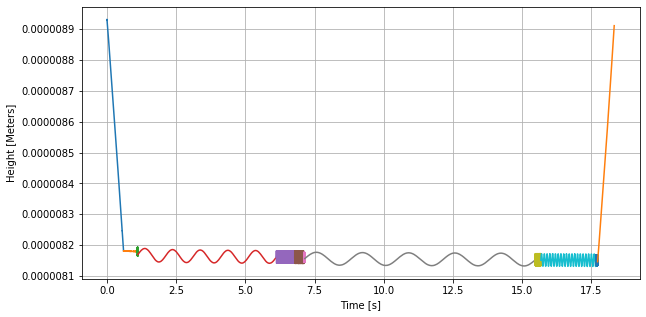

In [17]:
t0 = 0
for seg_id, segment in force_curve_segments:
    height = segment.segment_formated_data[height_channel]
    time = segment.segment_formated_data["time"] + t0
    plt.plot(time, height)
    t0 = time[-1]

plt.xlabel("Time [s]")
plt.ylabel("Height [Meters]")
plt.grid()
plt.show()

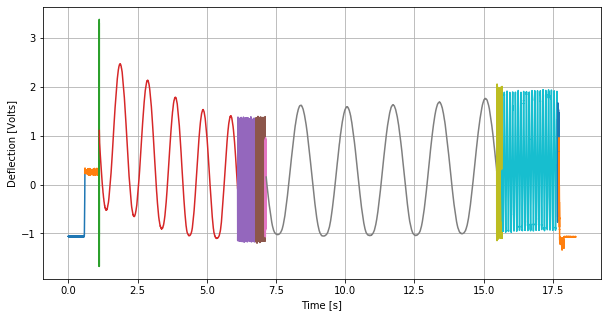

In [18]:
t0 = 0
for seg_id, segment in force_curve_segments:
    deflection = segment.segment_formated_data["vDeflection"]
    time = segment.segment_formated_data["time"] + t0
    plt.plot(time, deflection)
    t0 = time[-1]

plt.xlabel("Time [s]")
plt.ylabel("Deflection [Volts]")
plt.grid()
plt.show()

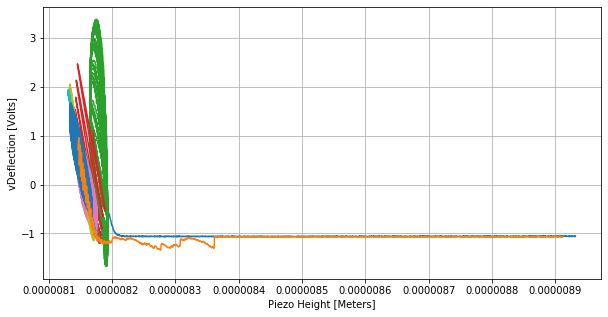

In [19]:
for seg_id, segment in force_curve_segments:
    height = segment.segment_formated_data[height_channel]
    deflection = segment.segment_formated_data["vDeflection"]
    plt.plot(height, deflection)

plt.xlabel("Piezo Height [Meters]")
plt.ylabel("vDeflection [Volts]")
plt.grid()
plt.show()

In [20]:
# Get retract, last retract segment
last_ret_seg_id, last_ret_seg = retract_segments[-1]
last_ret_seg.preprocess_segment(deflection_sensitivity, height_channel)

if modulation_segments:
    for seg_id, mod_seg in modulation_segments:
        mod_seg.preprocess_segment(deflection_sensitivity, height_channel)

In [21]:
# Shift height
xzero = last_ret_seg.zheight[-1] # Maximum height
if modulation_segments:
    for seg_id, mod_seg in modulation_segments:
        mod_seg.zheight = xzero - mod_seg.zheight

In [22]:
help(ComputePiezoLag)

Help on function ComputePiezoLag in module pyafmrheo.models.rheology:

ComputePiezoLag(zheight, deflection, fs, freq, nfft=None, freq_tol=0.0001)



In [23]:
results = []

for seg_id, mod_seg in modulation_segments:
    frequency = mod_seg.segment_metadata["frequency"]
    time = mod_seg.time
    zheight = mod_seg.zheight
    delfection = mod_seg.vdeflection
    deltat = time[1] - time[0]
    fs = 1 / deltat
    ntra_in, ntra_out, ntra_time =\
        detrend_rolling_average(frequency, zheight, delfection, time, 'indentation', 'force', [])
    fi, amp_quotient, gamma2 =\
        ComputePiezoLag(ntra_in, ntra_out, fs, frequency)
    results.append((frequency, fi, amp_quotient, gamma2))

results = sorted(results, key=lambda x: int(x[0]))
frequencies_results = [x[0] for x in results]
fi_results = [x[1] for x in results]
amp_quotient_results = [x[2] for x in results]

The frequency found at index 799.789529071297 does not match with the frequency applied 800.0
The frequency found at index 1999.4738226782424 does not match with the frequency applied 2000.0
The frequency found at index 0.9966777408637872 does not match with the frequency applied 1.0
The frequency found at index 59.98421468034728 does not match with the frequency applied 60.0
The frequency found at index 119.96842936069456 does not match with the frequency applied 120.0
The frequency found at index 1199.6842936069454 does not match with the frequency applied 1200.0
The frequency found at index 0.5980066445182725 does not match with the frequency applied 0.6
The frequency found at index 199.89479221462386 does not match with the frequency applied 200.0
The frequency found at index 9.994447529150474 does not match with the frequency applied 10.0


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/signal/spectral.py:1816: UserWarning: Input data is complex, switching to return_onesided=False
  warnings.warn('Input data is complex, switching to '


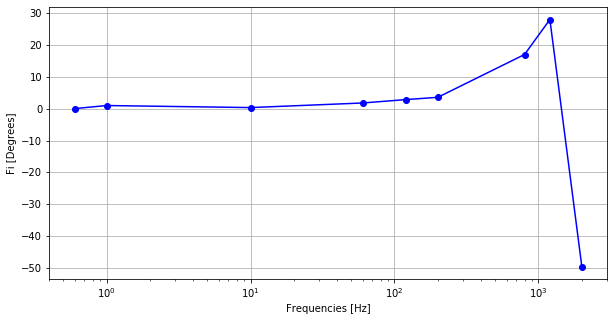

In [24]:
plt.plot(frequencies_results, fi_results, "bo-")
plt.xlabel("Frequencies [Hz]")
plt.ylabel("Fi [Degrees]")
plt.grid()
plt.xscale("log")
plt.show()

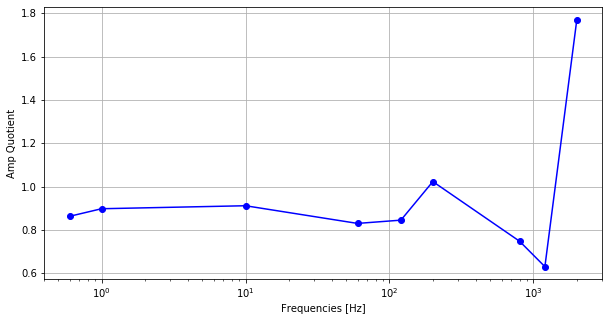

In [25]:
plt.plot(frequencies_results, amp_quotient_results, "bo-")
plt.xlabel("Frequencies [Hz]")
plt.ylabel("Amp Quotient")
plt.grid()
plt.xscale("log")
plt.show()